# Reddit Data Extraction

## Import Libraries

In [5]:
import sys
import pandas as pd
import json
import datetime
import re #regex
import requests #APIs
import praw #reddit API enhanced library
import ffn #stock data
from textblob import TextBlob
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow import keras #lstm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler


import pickle

#!{sys.executable} -m pip install praw
#!{sys.executable} -m pip install textblob
#!{sys.executable} -m pip install ffn
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install wordcloud
# Source: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/


## Read Data

Read data from previous section

In [25]:
df_wsb = pd.read_csv('pos_neg_sent_wsb.csv')

In [26]:
df_stocks = pd.read_csv('pos_neg_sent_stocks.csv')

In [63]:
df_kw_stocks = pd.read_csv('bull_bear_scores_stocks.csv')

In [101]:
df_kw_wsb = pd.read_csv('bull_bear_scores_wsb.csv')

## Collect Stock Data - Comments

In [27]:
## merge with spy price and plot

spy=ffn.get('spy', start='2017-01-01')

In [28]:
spy

,spy
Date,
2017-01-03,208.213501
2017-01-04,209.452240
2017-01-05,209.285812
2017-01-06,210.034561
2017-01-09,209.341278
...,...
2021-04-09,411.489990
2021-04-12,411.640015
2021-04-13,412.859985


In [29]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1078 entries, 2017-01-03 to 2021-04-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spy     1078 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


## Merge Datasets

In [30]:
#Convert date to datetime to allow for merging
df_stocks['date'] = df_stocks['date'].astype('datetime64[ns]')

In [31]:
df_stocks = pd.merge(df_stocks,spy,left_on='date',right_on='Date',how='inner')

In [32]:
df_stocks

,Unnamed: 0,Unnamed: 0.1,id,title,url,date,flair,sentiment score,spy
0,0,0,8q9egq,What happened to the daily stock discussion th...,https://www.reddit.com/r/stocks/comments/8q9eg...,2018-06-11,NaN,2.4699,263.560455
1,1,1,8qio6f,"Daily discussion - r/Stocks Tuesday - Jun 12, ...",https://www.reddit.com/r/stocks/comments/8qio6...,2018-06-12,NaN,1.2858,263.901062
2,2,2,8qrkat,Daily discussion - r/Stocks Wednesday - Jun 13...,https://www.reddit.com/r/stocks/comments/8qrka...,2018-06-13,NaN,0.3503,263.058929
3,3,3,8r0yzs,"Daily discussion - r/Stocks Thursday - Jun 14,...",https://www.reddit.com/r/stocks/comments/8r0yz...,2018-06-14,NaN,0.1511,263.721283
4,4,4,8ra3vn,"Daily discussion - r/Stocks Friday - Jun 15, 2018",https://www.reddit.com/r/stocks/comments/8ra3v...,2018-06-15,NaN,0.7227,263.384796
...,...,...,...,...,...,...,...,...,...
685,714,716,mkgpbr,"r/Stocks Daily Discussion Monday - Apr 05, 2021",https://www.reddit.com/r/stocks/comments/mkgpb...,2021-04-05,NaN,35.8456,406.359985
686,715,717,ml7rbq,r/Stocks Daily Discussion &amp; Technicals Tue...,https://www.reddit.com/r/stocks/comments/ml7rb...,2021-04-06,NaN,25.8704,406.119995
687,716,718,mlycbf,"r/Stocks Daily Discussion Wednesday - Apr 07, ...",https://www.reddit.com/r/stocks/comments/mlycb...,2021-04-07,NaN,30.9270,406.589996
688,717,719,mmo2go,r/Stocks Daily Discussion &amp; Options Tradin...,https://www.reddit.com/r/stocks/comments/mmo2g...,2021-04-08,NaN,41.9974,408.519989


In [33]:
#df_merge['spy']=spy_vals

df_stocks=df_stocks[['date','sentiment score','spy']]
df_stocks=df_stocks.set_index('date')
df_stocks=df_stocks[df_stocks['spy'].notna()]

In [34]:
df_stocks

,sentiment score,spy
date,,
2018-06-11,2.4699,263.560455
2018-06-12,1.2858,263.901062
2018-06-13,0.3503,263.058929
2018-06-14,0.1511,263.721283
2018-06-15,0.7227,263.384796
...,...,...
2021-04-05,35.8456,406.359985
2021-04-06,25.8704,406.119995
2021-04-07,30.9270,406.589996


In [35]:
#df_stocks.to_csv('pos_neg_sent_stocks.csv')

In [36]:
#Convert date to datetime to allow for merging
df_wsb['date'] = df_wsb['date'].astype('datetime64[ns]')

In [37]:
df_wsb = pd.merge(df_wsb,spy,left_on='date',right_on='Date',how='inner')

In [38]:
df_wsb

,Unnamed: 0,Unnamed: 0.1,id,title,url,date,flair,sentiment score,spy
0,1,1,7j4u75,"Daily Discussion Thread - December 11, 2017",https://www.reddit.com/r/wallstreetbets/commen...,2017-12-11,NaN,-0.6738,249.688629
1,2,2,7jjwwy,"Daily discussion - Dec 13, 2017",https://www.reddit.com/r/wallstreetbets/commen...,2017-12-13,NaN,2.1726,250.101181
2,3,3,7jr634,"Daily Discussion Thread - December 14, 2017",https://www.reddit.com/r/wallstreetbets/commen...,2017-12-14,NaN,-0.5143,249.079208
3,4,4,7kktzz,"Daily Discussion Thread - December 18, 2017",https://www.reddit.com/r/wallstreetbets/commen...,2017-12-18,NaN,1.9078,252.746033
4,5,5,7ksv7x,"Daily Discussion Thread - December 19, 2017",https://www.reddit.com/r/wallstreetbets/commen...,2017-12-19,NaN,2.9018,251.775375
...,...,...,...,...,...,...,...,...,...
812,854,1082,mkh463,"Daily Discussion Thread for April 05, 2021",https://www.reddit.com/r/wallstreetbets/commen...,2021-04-05,Daily Discussion,0.5726,406.359985
813,855,1084,ml86d3,"Daily Discussion Thread for April 06, 2021",https://www.reddit.com/r/wallstreetbets/commen...,2021-04-06,Daily Discussion,-0.0672,406.119995
814,856,1086,mlyq1y,"Unpinned Daily Discussion Thread for April 07,...",https://www.reddit.com/r/wallstreetbets/commen...,2021-04-07,Discussion,3.4779,406.589996
815,857,1088,mmog61,"Unpinned Daily Discussion Thread for April 08,...",https://www.reddit.com/r/wallstreetbets/commen...,2021-04-08,Discussion,-0.8960,408.519989


In [39]:
#df_merge['spy']=spy_vals

df_wsb=df_wsb[['date','sentiment score','spy']]
df_wsb=df_wsb.set_index('date')
df_wsb=df_wsb[df_wsb['spy'].notna()]

In [40]:
#df_wsb.to_csv('pos_neg_sent_wsb.csv')

In [41]:
df_wsb

,sentiment score,spy
date,,
2017-12-11,-0.6738,249.688629
2017-12-13,2.1726,250.101181
2017-12-14,-0.5143,249.079208
2017-12-18,1.9078,252.746033
2017-12-19,2.9018,251.775375
...,...,...
2021-04-05,0.5726,406.359985
2021-04-06,-0.0672,406.119995
2021-04-07,3.4779,406.589996


## Plot Results - WSB

<AxesSubplot:xlabel='date'>

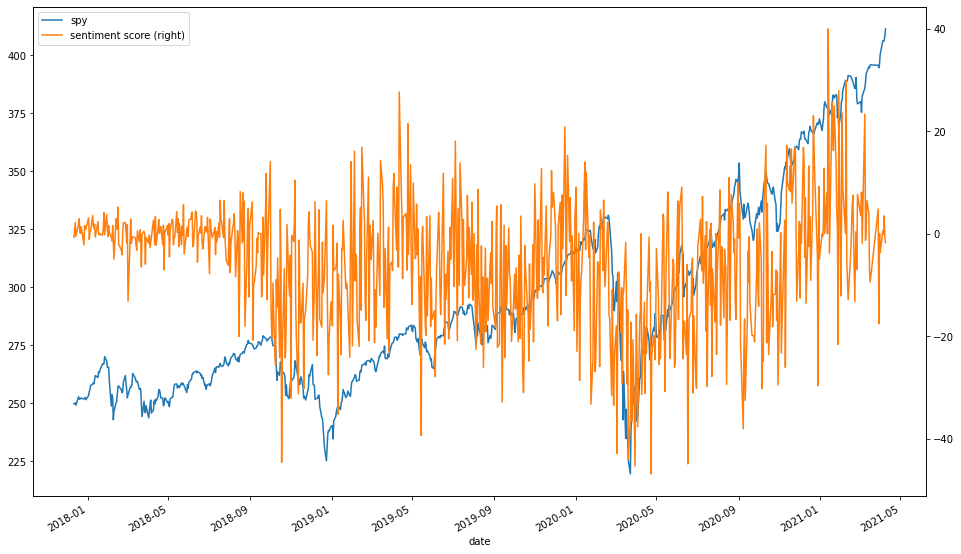

In [42]:
#fig = plt.figure()
#plt.plot(data)
#plt.xlabel('date', fontsize=18)
df_wsb[['spy','sentiment score']].plot(secondary_y='sentiment score', figsize=(16, 10))


#df_wsb[['spy', 'fourier 20']].plot(secondary_y='fourier 20', figsize=(16, 10))

### Fourier Transform

In [43]:
close_fft = np.fft.fft(np.asarray(df_wsb['sentiment score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())


In [44]:
for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_wsb['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

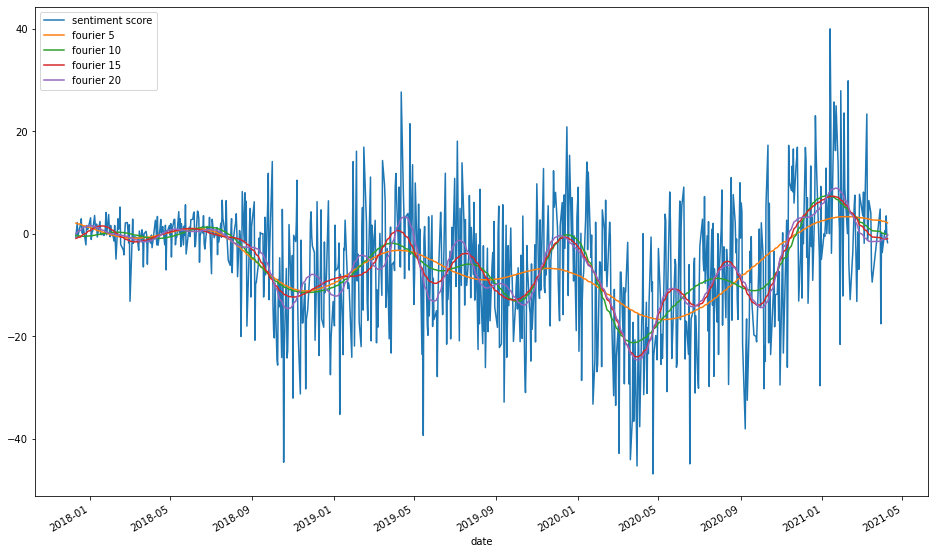

In [45]:
df_wsb[['sentiment score', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20']].plot(figsize=(16, 10))

In [46]:
df_wsb.head()

,sentiment score,spy,fourier 5,fourier 10,fourier 15,fourier 20
date,,,,,,
2017-12-11,-0.6738,249.688629,2.054370-0.508401j,-0.337551+0.567007j,-0.909126+0.794788j,0.045660-0.109067j
2017-12-13,2.1726,250.101181,1.985582-0.555904j,-0.382284+0.536603j,-0.828855+0.766640j,0.251123-0.139254j
2017-12-14,-0.5143,249.079208,1.915900-0.602584j,-0.419297+0.503027j,-0.733958+0.728301j,0.449618-0.166153j
2017-12-18,1.9078,252.746033,1.845413-0.648374j,-0.448857+0.466477j,-0.626102+0.680281j,0.637937-0.189129j
2017-12-19,2.9018,251.775375,1.774207-0.693206j,-0.471259+0.427170j,-0.507050+0.623218j,0.813236-0.207639j


C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

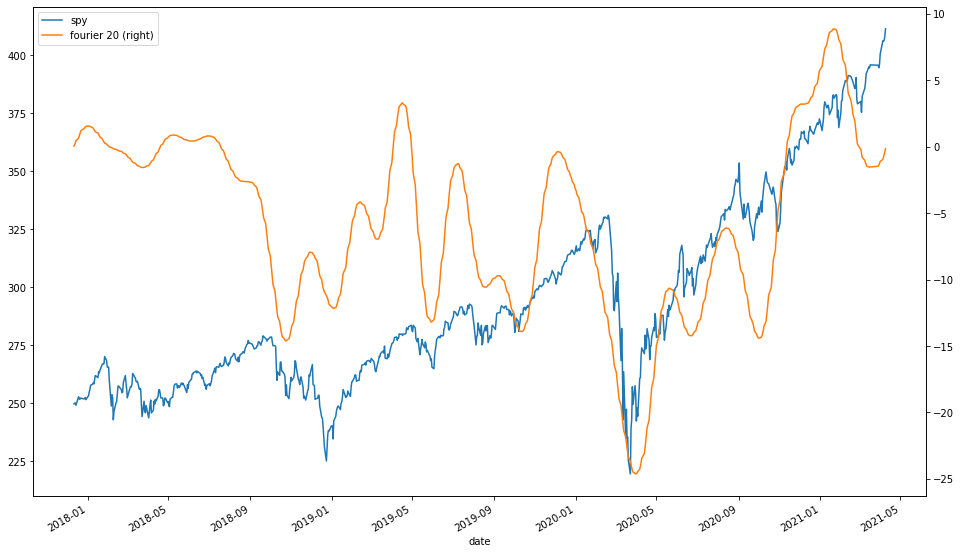

In [49]:
df_wsb[['spy', 'fourier 20']].plot(secondary_y='fourier 20', figsize=(16, 10))

## Normalize Data

In [50]:
sc= MinMaxScaler(feature_range=(0,1))
df_wsb['norm_price']=sc.fit_transform(df_wsb['spy'].to_numpy().reshape(-1, 1))
df_wsb['spy log']=np.log(df_wsb['spy']/df_wsb['spy'].shift(1))
df_wsb['norm_sentiment']=sc.fit_transform(df_wsb['sentiment score'].to_numpy().reshape(-1, 1))
df_wsb['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 5'].to_numpy()])).reshape(-1, 1))
df_wsb['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 10'].to_numpy()])).reshape(-1, 1))
df_wsb['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 15'].to_numpy()])).reshape(-1, 1))
df_wsb['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 20'].to_numpy()])).reshape(-1, 1))


<ipython-input-50-2cf9d09cbe32>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  df_wsb['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 5'].to_numpy()])).reshape(-1, 1))
<ipython-input-50-2cf9d09cbe32>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  df_wsb['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-50-2cf9d09cbe32>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  df_wsb['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 15'].to_numpy()])).reshape(-1, 1))
<ipython-input-50-2cf9d09cbe32>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  df_wsb['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_wsb['fourier 20'].to_numpy()])).reshape(-1, 1))


<AxesSubplot:xlabel='date'>

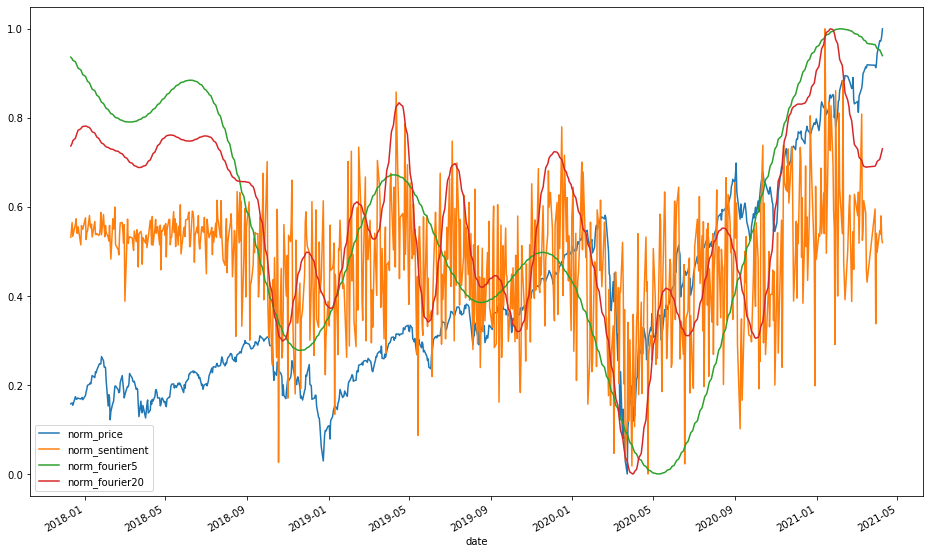

In [51]:

df_wsb[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier20']].plot(figsize=(16, 10))

In [52]:
df_wsb.to_csv('pos_neg_sent_wsb_full.csv')

## Plot Results - Stocks

<AxesSubplot:xlabel='date'>

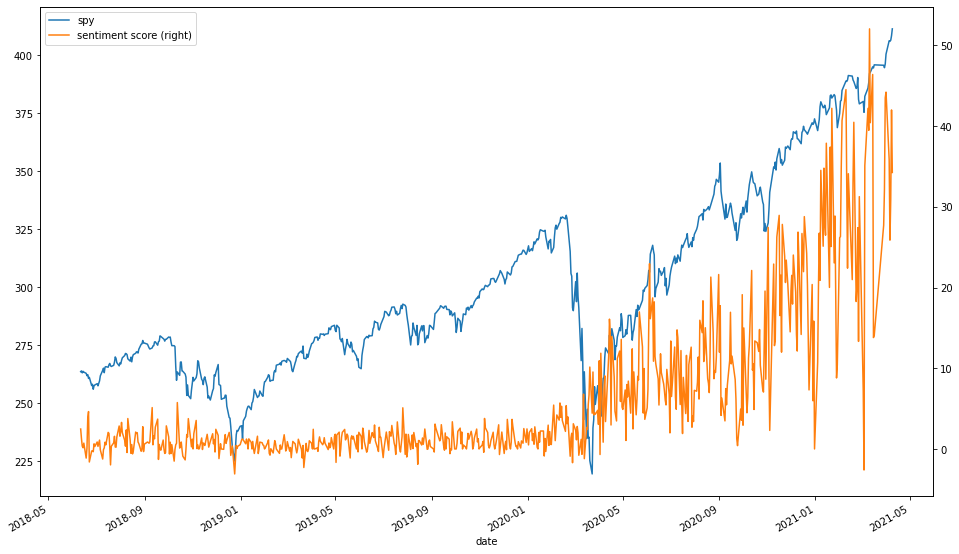

In [54]:
#fig = plt.figure()
#plt.plot(data)
#plt.xlabel('date', fontsize=18)
df_stocks[['spy','sentiment score']].plot(secondary_y='sentiment score', figsize=(16, 10))

### Fourier Transform

In [55]:
close_fft = np.fft.fft(np.asarray(df_stocks['sentiment score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())


In [56]:
for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_stocks['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

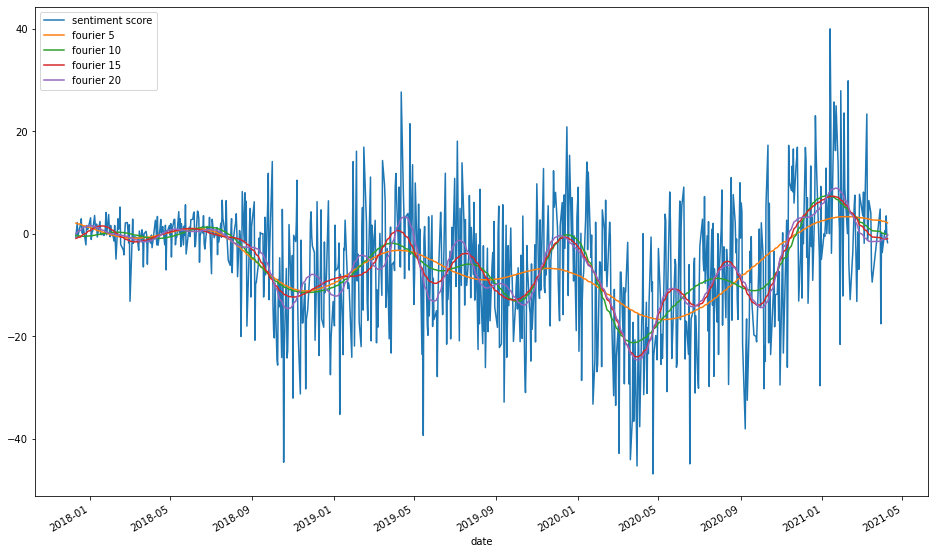

In [57]:
df_wsb[['sentiment score', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20']].plot(figsize=(16, 10))

In [58]:
df_stocks.head()

,sentiment score,spy,fourier 5,fourier 10,fourier 15,fourier 20
date,,,,,,
2018-06-11,2.4699,263.560455,15.908977-1.210142j,16.315441-0.649602j,16.058129-0.290722j,17.753338-0.376633j
2018-06-12,1.2858,263.901062,15.523985-1.203093j,15.476947-0.660745j,14.815572-0.332341j,15.941580-0.403225j
2018-06-13,0.3503,263.058929,15.136242-1.193550j,14.634721-0.666413j,13.575659-0.367769j,14.104060-0.416480j
2018-06-14,0.1511,263.721283,14.746115-1.181534j,13.791367-0.666558j,12.345660-0.396347j,12.263821-0.415960j
2018-06-15,0.7227,263.384796,14.353974-1.167068j,12.949487-0.661180j,11.132742-0.417541j,10.444112-0.401680j


C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

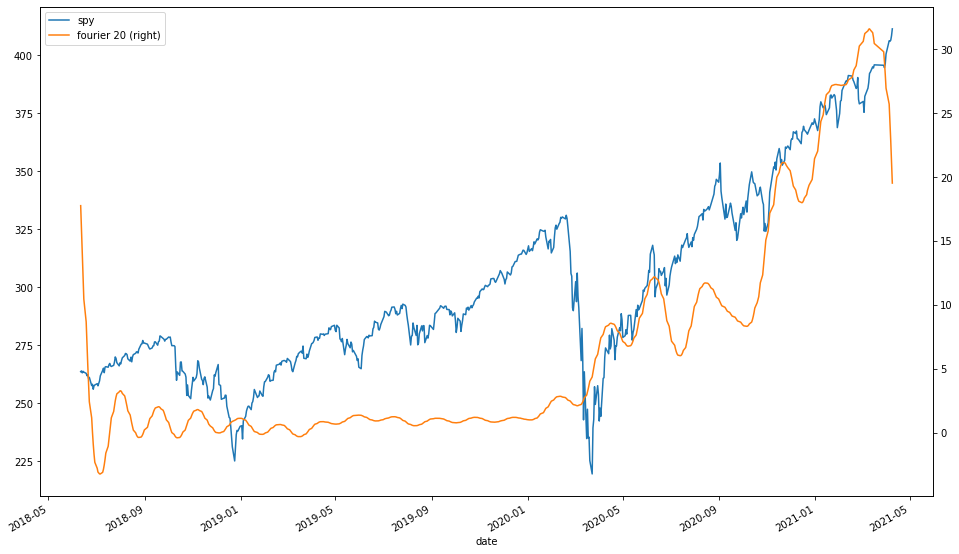

In [59]:
df_stocks[['spy', 'fourier 20']].plot(secondary_y='fourier 20', figsize=(16, 10))

## Normalize Data

In [60]:
sc= MinMaxScaler(feature_range=(0,1))
df_stocks['norm_price']=sc.fit_transform(df_stocks['spy'].to_numpy().reshape(-1, 1))
df_stocks['spy log']=np.log(df_stocks['spy']/df_stocks['spy'].shift(1))
df_stocks['norm_sentiment']=sc.fit_transform(df_stocks['sentiment score'].to_numpy().reshape(-1, 1))
df_stocks['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 5'].to_numpy()])).reshape(-1, 1))
df_stocks['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 10'].to_numpy()])).reshape(-1, 1))
df_stocks['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 15'].to_numpy()])).reshape(-1, 1))
df_stocks['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 20'].to_numpy()])).reshape(-1, 1))


<ipython-input-60-ba3dbaa71fe5>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  df_stocks['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 5'].to_numpy()])).reshape(-1, 1))
<ipython-input-60-ba3dbaa71fe5>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  df_stocks['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-60-ba3dbaa71fe5>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  df_stocks['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 15'].to_numpy()])).reshape(-1, 1))
<ipython-input-60-ba3dbaa71fe5>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  df_stocks['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_stocks['fourier 20'].to_numpy()])).reshape(-1, 1))


<AxesSubplot:xlabel='date'>

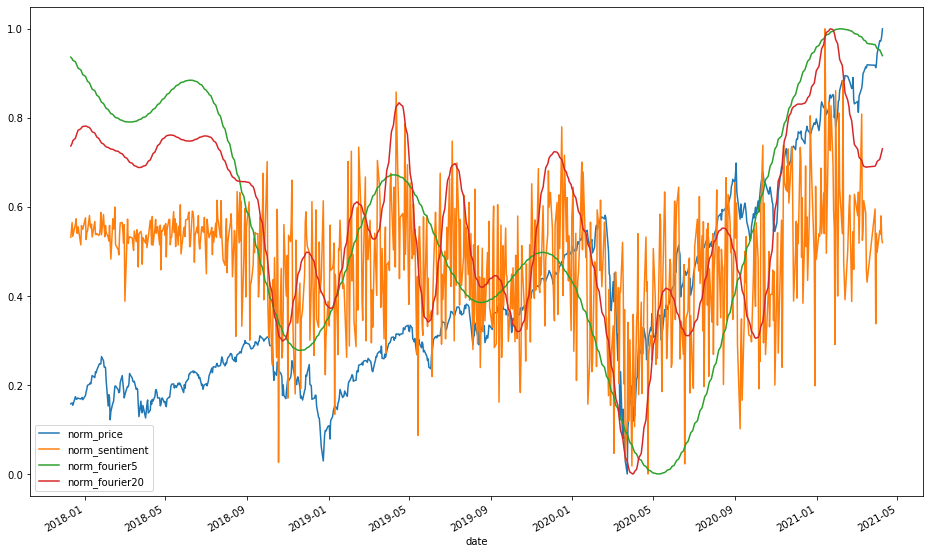

In [61]:

df_wsb[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier20']].plot(figsize=(16, 10))

In [62]:
df_stocks.to_csv('pos_neg_sent_stocks_full.csv')

## Collect Stock Data - Comments

In [102]:
df_kw_wsb

,Unnamed: 0,date,Unnamed: 0.1,bull score,bear score
0,0,2016-12-18,75,0.000000,0.000000
1,1,2016-12-19,690,0.000000,0.000000
2,2,2016-12-20,324,0.000000,0.000000
3,3,2016-12-21,848,0.000000,0.000000
4,4,2016-12-22,1587,0.333333,0.000000
...,...,...,...,...,...
1534,1534,2021-04-06,2055813307,0.118196,0.104977
1535,1535,2021-04-07,2062723340,0.143522,0.116369
1536,1536,2021-04-08,2388734100,0.131455,0.100604
1537,1537,2021-04-09,1571694686,0.115306,0.100000


In [64]:
df_kw_stocks

,Unnamed: 0,date,Unnamed: 0.1,bull score,bear score
0,0,2016-12-17,14,0.000000,0.000000
1,1,2016-12-20,92,0.000000,0.000000
2,2,2016-12-21,310,0.000000,0.000000
3,3,2016-12-27,2727,0.000000,0.000000
4,4,2016-12-28,603,0.000000,0.000000
...,...,...,...,...,...
1299,1299,2021-04-06,17934120,0.148148,0.055556
1300,1300,2021-04-07,5323558,0.125000,0.062500
1301,1301,2021-04-08,11993264,0.083333,0.166667
1302,1302,2021-04-09,10008703,0.100000,0.300000


In [65]:
spy

,spy
Date,
2017-01-03,208.213501
2017-01-04,209.452240
2017-01-05,209.285812
2017-01-06,210.034561
2017-01-09,209.341278
...,...
2021-04-09,411.489990
2021-04-12,411.640015
2021-04-13,412.859985


In [105]:
#Convert date to datetime to allow for merging
df_kw_stocks['date'] = df_kw_stocks['date'].astype('datetime64[ns]')
df_kw_wsb['date'] = df_kw_wsb['date'].astype('datetime64[ns]')

In [106]:
df_kw_stocks = pd.merge(df_kw_stocks,spy,left_on='date',right_on='Date',how='inner')
df_kw_wsb = pd.merge(df_kw_wsb,spy,left_on='date',right_on='Date',how='inner')


In [83]:
df_kw_stocks

,date,bull score,bear score,spy
0,2017-01-03,0.000000,0.000000,208.213501
1,2017-01-04,0.000000,0.000000,209.452240
2,2017-01-05,0.000000,1.000000,209.285812
3,2017-01-09,0.000000,0.000000,209.341278
4,2017-01-11,0.000000,0.000000,209.932907
...,...,...,...,...
947,2021-04-06,0.148148,0.055556,406.119995
948,2021-04-07,0.125000,0.062500,406.589996
949,2021-04-08,0.083333,0.166667,408.519989
950,2021-04-09,0.100000,0.300000,411.489990


In [107]:
#df_merge['spy']=spy_vals

df_kw_stocks=df_kw_stocks[['date','bull score','bear score','spy']]
df_kw_wsb=df_kw_wsb[['date','bull score','bear score','spy']]

In [108]:
df_kw_stocks.reset_index(drop=False, inplace=True)
df_kw_wsb.reset_index(drop=False, inplace=True)
#Source: https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-dataframe

In [109]:
df_kw_stocks=df_kw_stocks.set_index('date')
df_kw_stocks=df_kw_stocks[df_kw_stocks['spy'].notna()]

df_kw_wsb=df_kw_wsb.set_index('date')
df_kw_wsb=df_kw_wsb[df_kw_wsb['spy'].notna()]

In [86]:
df_kw_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 952 entries, 2017-01-03 to 2021-04-13
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       952 non-null    int64  
 1   bull score  952 non-null    float64
 2   bear score  952 non-null    float64
 3   spy         952 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 37.2 KB


In [110]:
df_kw_wsb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1065 entries, 2017-01-03 to 2021-04-13
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       1065 non-null   int64  
 1   bull score  1065 non-null   float64
 2   bear score  1065 non-null   float64
 3   spy         1065 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 41.6 KB


In [78]:
df_kw_stocks.to_csv('df_kw_stocks_full.csv')

In [111]:
df_kw_wsb.to_csv('df_kw_wsb_full.csv')

## Plot Scores with Spy - WSB

<AxesSubplot:xlabel='date'>

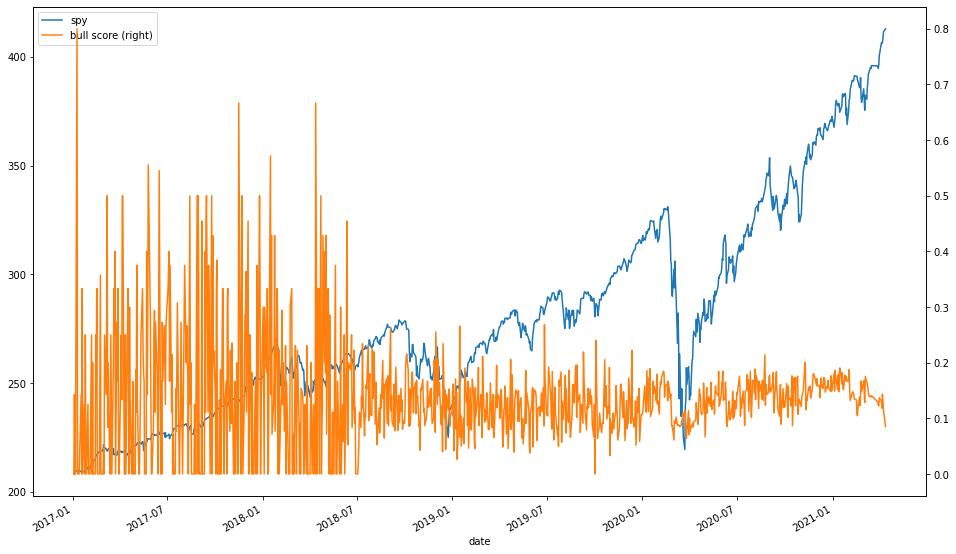

In [113]:
df_kw_wsb[['spy', 'bull score']].plot(secondary_y='bull score', figsize=(16, 10))

<AxesSubplot:xlabel='date'>

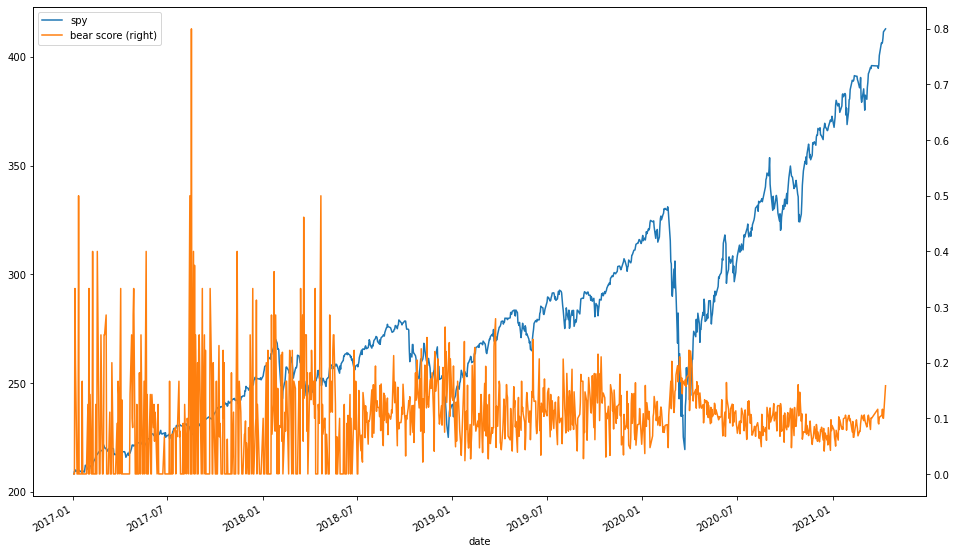

In [114]:
df_kw_wsb[['spy', 'bear score']].plot(secondary_y='bear score', figsize=(16, 10))

### Fourier Transformations

In [115]:
close_fft = np.fft.fft(np.asarray(df_kw_wsb['bull score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_kw_wsb['fourier bull '+str(num_)]=np.fft.ifft(fft_list_m10)

close_fft = np.fft.fft(np.asarray(df_kw_wsb['bear score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_kw_wsb['fourier bear '+str(num_)]=np.fft.ifft(fft_list_m10)

C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

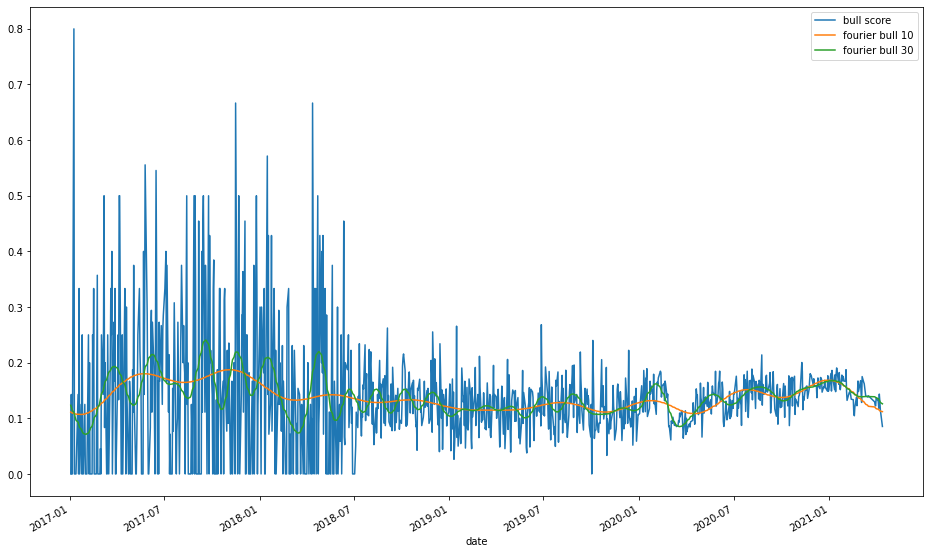

In [116]:
df_kw_wsb[['bull score', 'fourier bull 10', 'fourier bull 30']].plot(figsize=(16, 10))

C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

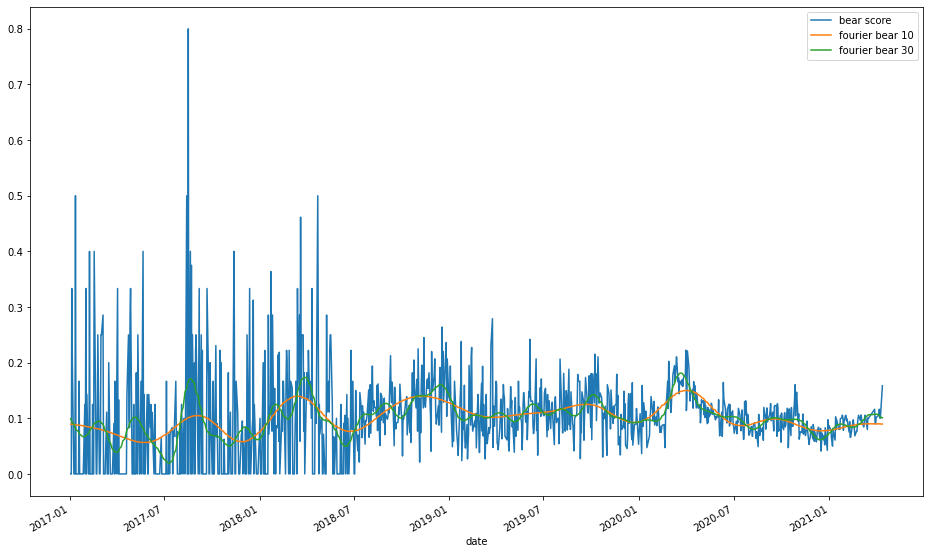

In [117]:
df_kw_wsb[['bear score', 'fourier bear 10', 'fourier bear 30']].plot(figsize=(16, 10))

In [118]:
#normalize
sc= MinMaxScaler(feature_range=(0,1))
df_kw_wsb['norm_price']=sc.fit_transform(df_kw_wsb['spy'].to_numpy().reshape(-1, 1))
df_kw_wsb['spy log']=np.log(df_kw_wsb['spy']/df_kw_wsb['spy'].shift(1))
df_kw_wsb['norm_bull']=sc.fit_transform(df_kw_wsb['bull score'].to_numpy().reshape(-1, 1))
df_kw_wsb['norm_bear']=sc.fit_transform(df_kw_wsb['bear score'].to_numpy().reshape(-1, 1))
df_kw_wsb['norm_fourier_bull_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier bull 10'].to_numpy()])).reshape(-1, 1))
df_kw_wsb['norm_fourier_bear_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier bear 10'].to_numpy()])).reshape(-1, 1))
df_kw_wsb['norm_fourier_bull_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier bull 30'].to_numpy()])).reshape(-1, 1))
df_kw_wsb['norm_fourier_bear_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier bear 30'].to_numpy()])).reshape(-1, 1))

<ipython-input-118-d580b88a362c>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_wsb['norm_fourier_bull_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier bull 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-118-d580b88a362c>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_wsb['norm_fourier_bear_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier bear 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-118-d580b88a362c>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_wsb['norm_fourier_bull_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier bull 30'].to_numpy()])).reshape(-1, 1))
<ipython-input-118-d580b88a362c>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_wsb['norm_fourier_bear_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_wsb['fourier

<AxesSubplot:xlabel='date'>

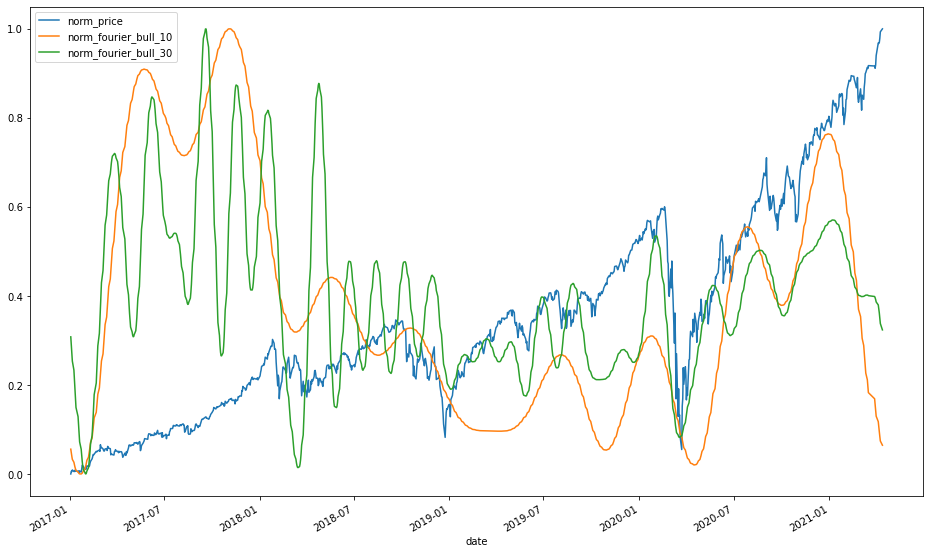

In [119]:
df_kw_wsb[['norm_price', 'norm_fourier_bull_10', 'norm_fourier_bull_30']].plot(figsize=(16, 10))

<AxesSubplot:xlabel='date'>

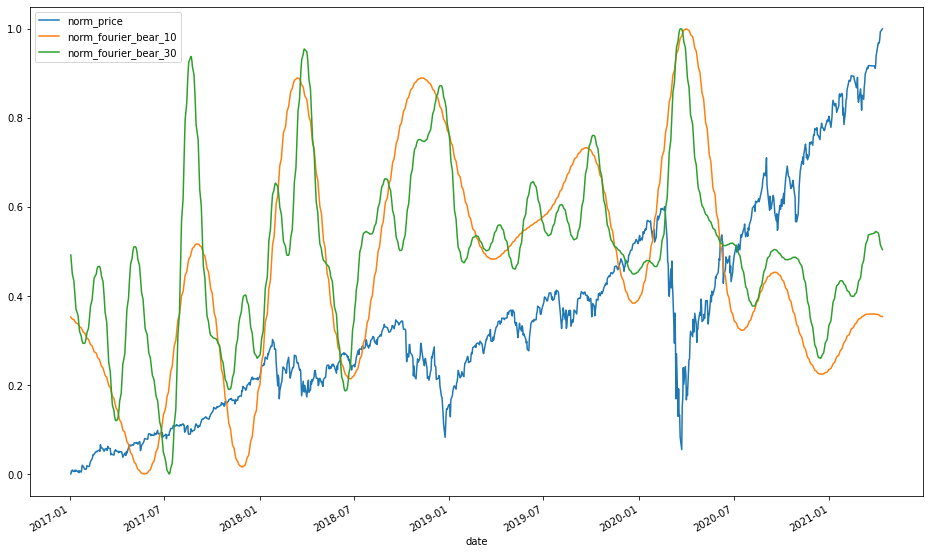

In [120]:
df_kw_wsb[['norm_price', 'norm_fourier_bear_10', 'norm_fourier_bear_30']].plot(figsize=(16, 10))

In [121]:
df_kw_wsb.to_csv('df_kw_wsb_full.csv')

## Plot Scores with Spy - Stocks

<AxesSubplot:xlabel='date'>

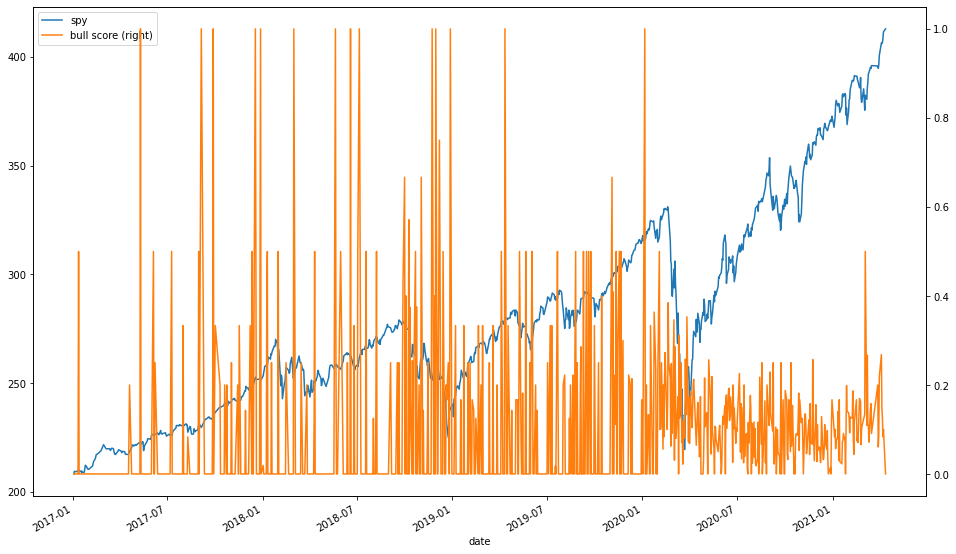

In [87]:
df_kw_stocks[['spy', 'bull score']].plot(secondary_y='bull score', figsize=(16, 10))

<AxesSubplot:xlabel='date'>

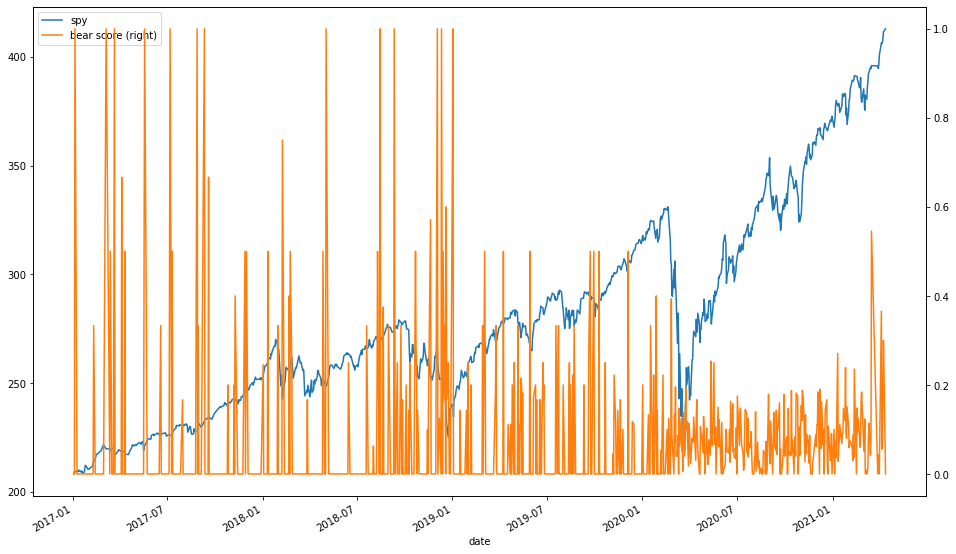

In [88]:
df_kw_stocks[['spy', 'bear score']].plot(secondary_y='bear score', figsize=(16, 10))

### Fourier Transformations

In [90]:
close_fft = np.fft.fft(np.asarray(df_kw_stocks['bull score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_kw_stocks['fourier bull '+str(num_)]=np.fft.ifft(fft_list_m10)

close_fft = np.fft.fft(np.asarray(df_kw_stocks['bear score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_kw_stocks['fourier bear '+str(num_)]=np.fft.ifft(fft_list_m10)

C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

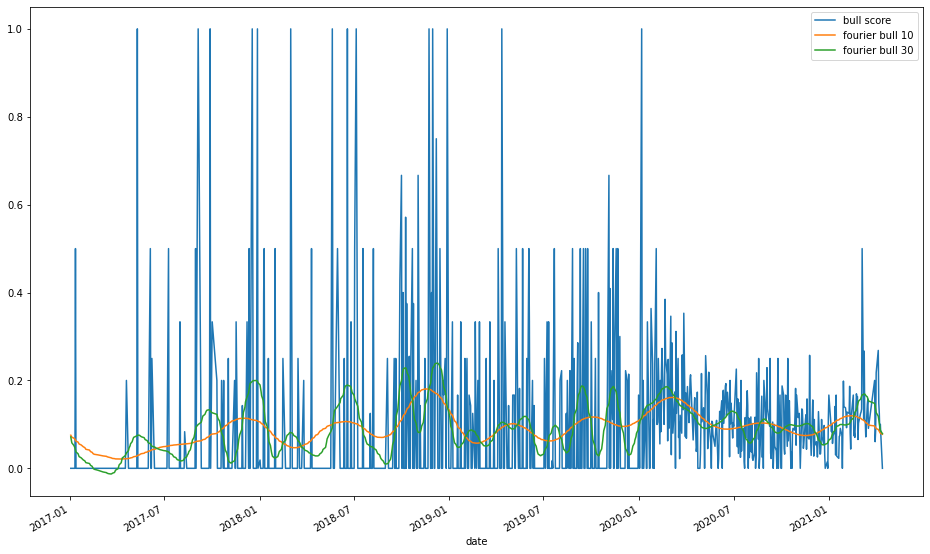

In [91]:
df_kw_stocks[['bull score', 'fourier bull 10', 'fourier bull 30']].plot(figsize=(16, 10))

C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\P2773714\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='date'>

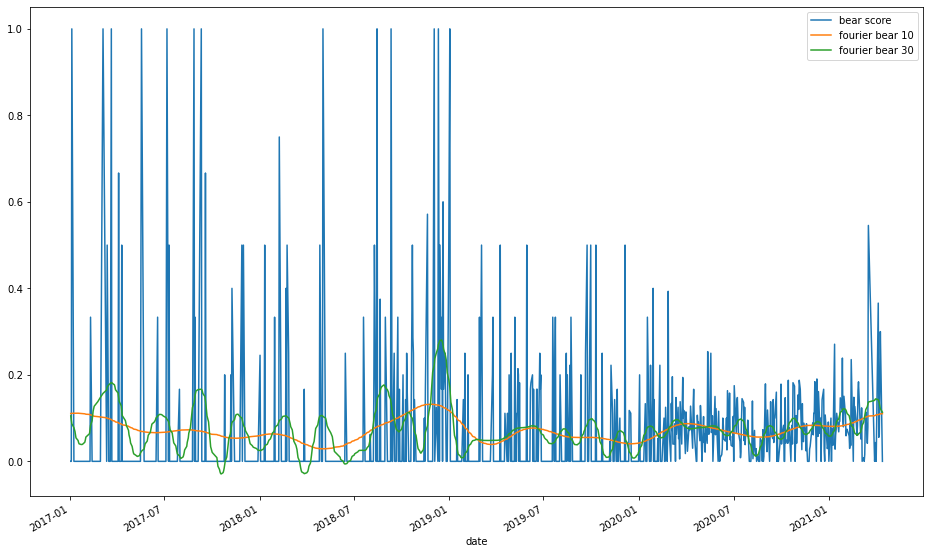

In [92]:
df_kw_stocks[['bear score', 'fourier bear 10', 'fourier bear 30']].plot(figsize=(16, 10))

In [93]:
#normalize
sc= MinMaxScaler(feature_range=(0,1))
df_kw_stocks['norm_price']=sc.fit_transform(df_kw_stocks['spy'].to_numpy().reshape(-1, 1))
df_kw_stocks['spy log']=np.log(df_kw_stocks['spy']/df_kw_stocks['spy'].shift(1))
df_kw_stocks['norm_bull']=sc.fit_transform(df_kw_stocks['bull score'].to_numpy().reshape(-1, 1))
df_kw_stocks['norm_bear']=sc.fit_transform(df_kw_stocks['bear score'].to_numpy().reshape(-1, 1))
df_kw_stocks['norm_fourier_bull_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_stocks['fourier bull 10'].to_numpy()])).reshape(-1, 1))
df_kw_stocks['norm_fourier_bear_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_stocks['fourier bear 10'].to_numpy()])).reshape(-1, 1))
df_kw_stocks['norm_fourier_bull_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_stocks['fourier bull 30'].to_numpy()])).reshape(-1, 1))
df_kw_stocks['norm_fourier_bear_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_stocks['fourier bear 30'].to_numpy()])).reshape(-1, 1))

<ipython-input-93-38186ba1a0c5>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_stocks['norm_fourier_bull_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_stocks['fourier bull 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-93-38186ba1a0c5>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_stocks['norm_fourier_bear_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_stocks['fourier bear 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-93-38186ba1a0c5>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_stocks['norm_fourier_bull_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_kw_stocks['fourier bull 30'].to_numpy()])).reshape(-1, 1))
<ipython-input-93-38186ba1a0c5>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  df_kw_stocks['norm_fourier_bear_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in d

<AxesSubplot:xlabel='date'>

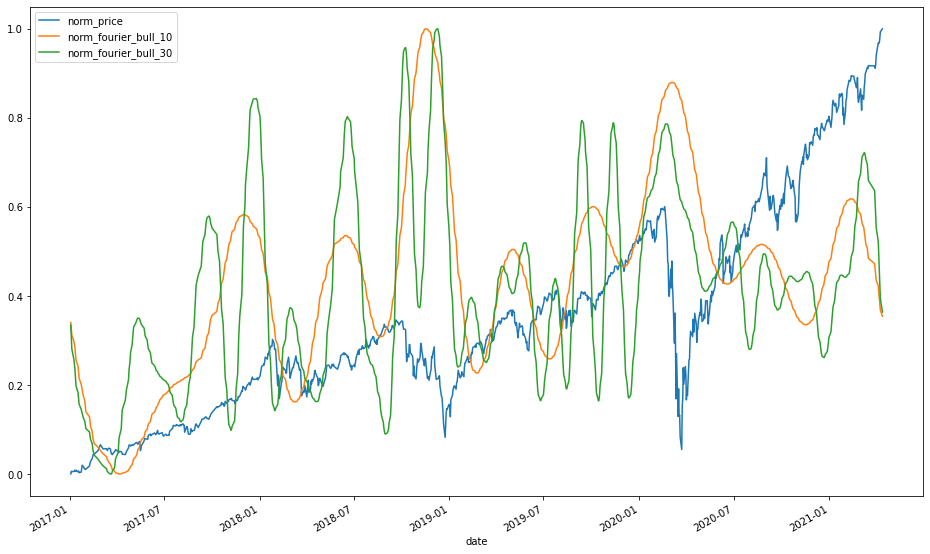

In [94]:
df_kw_stocks[['norm_price', 'norm_fourier_bull_10', 'norm_fourier_bull_30']].plot(figsize=(16, 10))

<AxesSubplot:xlabel='date'>

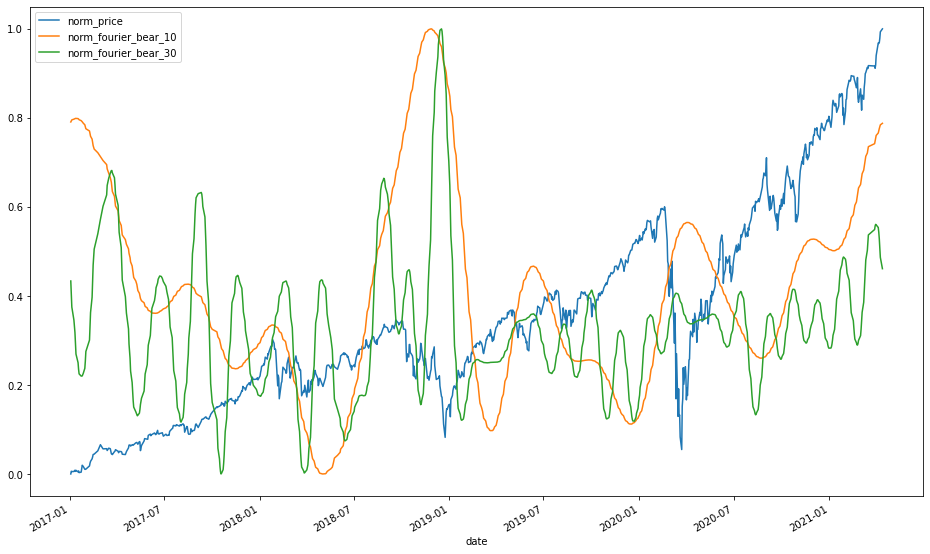

In [95]:
df_kw_stocks[['norm_price', 'norm_fourier_bear_10', 'norm_fourier_bear_30']].plot(figsize=(16, 10))

In [96]:
df_kw_stocks.to_csv('df_kw_stocks_full.csv')

## Correlation Between Fourier-Normalized Sentiment and Normalized Price

In [99]:
df_wsb[['norm_fourier20', 'norm_price']].corr()

,norm_fourier20,norm_price
norm_fourier20,1.000000,0.253898
norm_price,0.253898,1.000000


In [100]:
df_stocks[['norm_fourier20', 'norm_price']].corr()

,norm_fourier20,norm_price
norm_fourier20,1.000000,0.837888
norm_price,0.837888,1.000000


In [ ]:
#sent_wsb_full_df    

#bull_bear_wsb_full_df

Sources: 


https://www.reddit.com/dev/api/

https://praw.readthedocs.io/en/latest/index.html

In [2]:
#Source: https://medium.com/analytics-vidhya/sentiment-analysis-for-trading-with-reddit-text-data-73729c931d01